# Using Cross-Validation to Solve Anscombe's Quartet

[Anscombe's Quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet) is a collection of four data sets with nearly exactly the same summary statistics. It was developed by statistician Francis Anscombe in 1973 to illustrate the importance of plotting data and the impact of outliers on statistical analysis. 

We can "solve" Anscombe's Quartet with [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) in the sense that we can use statistics to determine which of the four data sets are *actualy* well represented by a linear model. Before we dive in, let's take a look at the data sets. [Seaborn](https://seaborn.pydata.org/) provides an easy way to load Anscombe's Quartet, as shown below.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold

In [2]:
df = sns.load_dataset("anscombe")

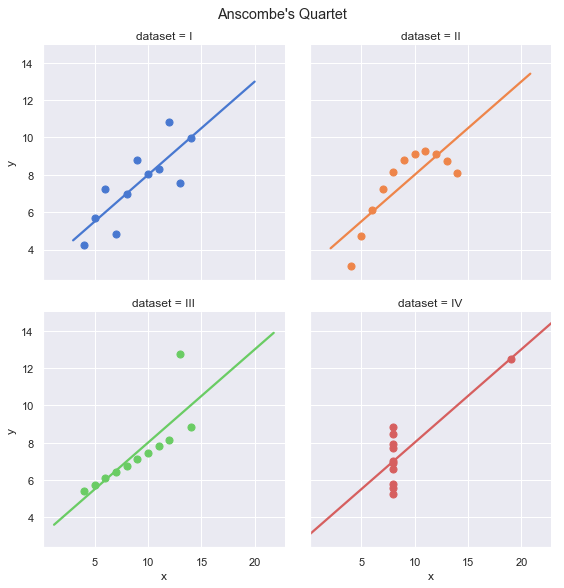

In [3]:
sns.lmplot(x="x", y="y", col="dataset", hue="dataset", data=df,
           col_wrap=2, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1})
plt.gcf().suptitle("Anscombe's Quartet", x=0.5, y=1.02)
plt.tight_layout()
plt.show()

Visually, the four data sets look quite different. Group `I` is the only group that actually seems to be observations of a linear relationship with random noise. However, they all appears to have the same linear regression line. 

Next, let's calculate all the summary statistics, to show that they are identical.

In [4]:
grouped = df.groupby('dataset')
summary_results = pd.DataFrame(columns=['mean_x', 'mean_y', 'std_x', 'std_y', 'correlation', 'slope', 'offset', 'R2'])
for key in grouped.groups.keys():
    data = grouped.get_group(key)
    fit = LinearRegression().fit(data['x'].values.reshape(-1, 1), data['y'].values)
    slope = fit.coef_[0]
    offset = fit.intercept_
    r2 = fit.score(data['x'].values.reshape(-1, 1), data['y'].values)
    summary_results.loc[key] = (
        grouped.mean().loc[key]['x'],
        np.round(grouped.mean().loc[key]['y'], 2),
        np.round(grouped.std().loc[key]['x'], 5),
        np.round(grouped.std().loc[key]['y'], 2),
        np.round(grouped.corr().loc[(key, 'x')]['y'], 3),
        np.round(slope, 3),
        np.round(offset, 2),
        np.round(r2, 2)
    )
summary_results

,mean_x,mean_y,std_x,std_y,correlation,slope,offset,R2
I,9.0,7.5,3.31662,2.03,0.816,0.5,3.0,0.67
II,9.0,7.5,3.31662,2.03,0.816,0.5,3.0,0.67
III,9.0,7.5,3.31662,2.03,0.816,0.5,3.0,0.67
IV,9.0,7.5,3.31662,2.03,0.817,0.5,3.0,0.67


As expected, all summary statistics are (nearly) identical. But what if we wanted to actually figure out which data set is best described by the linear model? We can do that with cross-validation.

The idea of cross-validation is simple, you randomly hold out some amount of your data, and fit the model with the reduced set. Then, you predict on the hold out set and look at the residuals. This process is repeated $k$ times ("$k$-fold cross-validation"), so that every piece of data is in the test set exactly once. Finally, you calculate the standard deviation ([RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation)) and mean ([MBE](https://en.wikipedia.org/wiki/Bias_of_an_estimator)) of all the residuals. A "good" model will have low RMSE and nearly zero MBE.

We can repeat this process for each of the four groups in Anscombe's Quartet. Typically, we use cross-validation to pick the best model for a data set. In this case, we are finding which data set best fits a simple linear regresssion model.

In [5]:
hold_out_validation = pd.DataFrame(columns=['rmse', 'mbe'])
for key in grouped.groups.keys():
    data = grouped.get_group(key)
    X = data['x'].values.reshape(-1, 1)
    y = data['y'].values
    splits = KFold(n_splits=3, shuffle=True, random_state=42).split(X)
    residuals = []
    for train_ix, test_ix in splits:
        fit = LinearRegression().fit(X[train_ix], y[train_ix])
        y_pred = fit.predict(X[test_ix])
        residuals.append(y[test_ix] - y_pred)
    residuals = np.concatenate(residuals)
    hold_out_validation.loc[key] = (np.std(residuals), np.mean(residuals))
hold_out_validation

,rmse,mbe
I,1.222849,-0.050753
II,1.360473,-0.145880
III,1.439326,0.208448
IV,1.944016,0.497576


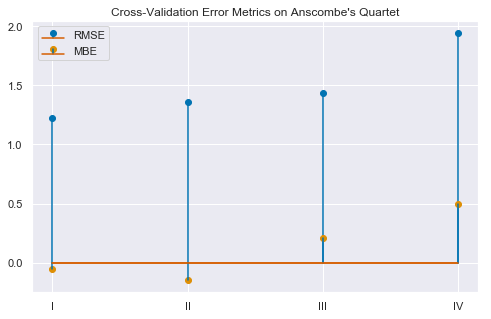

In [6]:
plt.figure(figsize=(8, 5))
plt.stem(hold_out_validation['rmse'], label='RMSE')
plt.stem(hold_out_validation['mbe'], markerfmt='C1o', label='MBE')
plt.xticks([0, 1, 2, 3], list(hold_out_validation.index))
plt.legend()
plt.title("Cross-Validation Error Metrics on Anscombe's Quartet");

Perfect! Group `I` has the lowest RMSE and MBE in the Quartet. 

### Conclusions

Traditional measures such as [correlation](https://en.wikipedia.org/wiki/Correlation_and_dependence) and [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) do not provide useful insight into which of the four groups is well characterized by a linear model. More generally, these measures do not do a good job of helping an analyst with model selection. 

[Model selection and validation procedures](https://scikit-learn.org/stable/model_selection.html) have been developed by the machine learning community as an alternative to these traditional measures. These newer procedures focus on the "predictive power" of a model. Typically these methods are deployed when trying to select between various fancy, non-linear ML models (say, different forms of a [deep neural network](https://scikit-learn.org/stable/modules/neural_networks_supervised.html)). However, the Anscombe's Quartet example shows that these procedures are also quite useful when evaluating linear models.